# 生成csv

In [2]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/3/20 10:30
*  @Project :   pj_gptp_simulation
*  @Description :   Run simulation and save results to CSV
*  @FileName:   simulation_runner.py
**************************************
"""
import numpy as np
from tqdm import tqdm
import csv
import os

class TimeAwareSystem:
    def __init__(self, id, initial_drift_rate=None):
        self.id = id
        # 随机初始化时钟漂移率 [-10, 10] ppm
        if initial_drift_rate is None:
            self.initial_drift_rate = np.random.uniform(-10e-6, 10e-6)
        else:
            self.initial_drift_rate = initial_drift_rate

        self.drift_rate = self.initial_drift_rate
        self.drift_rate_change = 0
        self.clock_time = 0
        self.last_sync_time = 0
        self.neighbor_rate_ratio = 1.0

        # 传播延迟测量结果
        self.propagation_delay = 0
        self.propagation_delay_history = []

        # 同步记录
        self.time_errors = []

    def update_clock(self, time_step):
        # 更新时钟漂移率变化 (最大1ppm/s)
        self.drift_rate_change += np.random.uniform(0, 1e-6 * time_step)
        self.drift_rate = self.initial_drift_rate + self.drift_rate_change

        # 更新时钟时间
        self.clock_time += time_step * (1 + self.drift_rate)

    def calculate_neighbor_rate_ratio(self, previous_tas):
        # 计算邻居速率比
        exact_ratio = (1 + previous_tas.drift_rate) / (1 + self.drift_rate)
        # 添加最大0.1ppm的误差
        error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = exact_ratio + error
        return self.neighbor_rate_ratio

    def measure_propagation_delay(self, previous_tas, real_delay=25e-9):
        # 考虑真实的传播时延对应的是5m的网线。
        # PHY抖动 [0, 8] ns
        jitter1 = np.random.uniform(0, 8e-9)
        jitter2 = np.random.uniform(0, 8e-9)
        jitter3 = np.random.uniform(0, 8e-9)
        jitter4 = np.random.uniform(0, 8e-9)

        # 时钟粒度 8ns
        granularity = 8e-9

        # t1: 发送Pdelay_Req的时间
        t1 = self.clock_time + np.random.uniform(0, granularity)

        # t2: 接收Pdelay_Req的时间
        t2_perfect = t1 * (1 + self.drift_rate) / (1 + previous_tas.drift_rate) + real_delay + jitter1
        t2 = t2_perfect - (t2_perfect % granularity) + np.random.uniform(0, granularity)

        # t3: 发送Pdelay_Resp的时间
        t3 = t2 + 1e-3  # 1ms的驻留时间

        # t4: 接收Pdelay_Resp的时间
        t4_perfect = t3 * (1 + previous_tas.drift_rate) / (1 + self.drift_rate) + real_delay + jitter2
        t4 = t4_perfect - (t4_perfect % granularity) + np.random.uniform(0, granularity)

        # 根据公式(4)计算传播延迟
        measured_delay = 0.5 * ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2))
        self.propagation_delay = measured_delay
        self.propagation_delay_history.append(measured_delay)

        # 使用累积平均值
        if len(self.propagation_delay_history) > 1:
            self.propagation_delay = np.mean(self.propagation_delay_history)

        return self.propagation_delay

    def receive_sync(self, previous_tas, gm_time, sync_info):
        # 记录接收时间
        receive_time = self.clock_time

        # PHY抖动
        jitter = np.random.uniform(0, 8e-9)

        # 时钟粒度
        granularity = 8e-9
        receive_time_with_error = receive_time + jitter
        receive_time_with_error = receive_time_with_error - (receive_time_with_error % granularity) + np.random.uniform(
            0, granularity)

        # 提取同步信息
        origin_timestamp, correction_field, rate_ratio = sync_info

        # 更新速率比 - 公式(1)
        updated_rate_ratio = rate_ratio * self.neighbor_rate_ratio

        # 计算从接收到发送的驻留时间
        residence_time = np.random.uniform(0, 1e-3)  # 最大1ms

        # 更新修正字段 - 公式(2)
        updated_correction_field = correction_field + self.propagation_delay + (residence_time * updated_rate_ratio)

        # 计算主时钟时间 - 公式(3)
        estimated_gm_time = origin_timestamp + updated_correction_field

        # 计算并记录时间误差
        time_error = receive_time - estimated_gm_time
        self.time_errors.append((gm_time, time_error))

        # 更新本地时钟
        self.clock_time = estimated_gm_time
        self.last_sync_time = receive_time

        # 返回更新后的同步信息
        send_time = self.clock_time + residence_time
        return send_time, (origin_timestamp, updated_correction_field, updated_rate_ratio)


def run_simulation(num_tas=100, duration=100, sync_interval=31.25e-3, pdelay_interval=1.0):
    # 创建时间感知系统
    tas_list = [TimeAwareSystem(i) for i in range(num_tas + 1)]  # +1 for grandmaster

    # 主时钟
    grandmaster = tas_list[0]

    # 仿真时间
    current_time = 0
    next_sync_time = 0
    next_pdelay_time = 0

    # 用于存储结果的数据结构
    sync_precision_data = {i: [] for i in range(1, num_tas + 1)}

    # 主循环
    with tqdm(total=int(duration / sync_interval)) as pbar:
        while current_time < duration:
            # 更新所有时钟
            time_step = min(sync_interval / 10,
                            next_sync_time - current_time if next_sync_time > current_time else sync_interval / 10)
            for tas in tas_list:
                tas.update_clock(time_step)

            current_time += time_step

            # 执行同步
            if current_time >= next_sync_time:
                # 主时钟发送同步信息
                sync_time = grandmaster.clock_time
                sync_info = (sync_time, 0, 1.0)  # (origin_timestamp, correction_field, rate_ratio)

                # 沿链路传递同步信息
                for i in range(1, num_tas + 1):
                    prev_tas = tas_list[i - 1]
                    current_tas = tas_list[i]

                    # 如果这是第一次同步，先测量传播延迟
                    if not current_tas.propagation_delay_history:
                        current_tas.calculate_neighbor_rate_ratio(prev_tas)
                        current_tas.measure_propagation_delay(prev_tas)

                    # 接收同步信息并更新
                    _, sync_info = current_tas.receive_sync(prev_tas, grandmaster.clock_time, sync_info)

                    # 记录同步精度
                    time_error = abs(current_tas.clock_time - grandmaster.clock_time)
                    sync_precision_data[i].append((current_time, time_error))

                next_sync_time = current_time + sync_interval
                pbar.update(1)

            # 执行传播延迟测量
            if current_time >= next_pdelay_time:
                for i in range(1, num_tas + 1):
                    prev_tas = tas_list[i - 1]
                    current_tas = tas_list[i]
                    current_tas.calculate_neighbor_rate_ratio(prev_tas)
                    current_tas.measure_propagation_delay(prev_tas)

                next_pdelay_time = current_time + pdelay_interval

    return tas_list, sync_precision_data


def save_results_to_csv(sync_precision_data, filename="simulation_results_3125ms.csv"):
    # 确保输出目录存在
    os.makedirs("output_data", exist_ok=True)
    
    with open(f"output_data/{filename}", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        # 写入表头
        writer.writerow(["TAS_ID", "Time", "Time_Error"])
        
        # 写入数据
        for tas_id in sync_precision_data:
            for time, error in sync_precision_data[tas_id]:
                writer.writerow([tas_id, time, error])


def propagation_delay_simulation():
    # 模拟传播延迟测量
    tas1 = TimeAwareSystem(1, initial_drift_rate=5e-6)  # 5ppm
    tas2 = TimeAwareSystem(2, initial_drift_rate=-3e-6)  # -3ppm

    delays = []
    avg_delays = []
    cumulative_avg = 0

    for i in range(1000):
        tas1.update_clock(1.0)  # 更新1秒
        tas2.update_clock(1.0)

        tas2.calculate_neighbor_rate_ratio(tas1)
        delay = tas2.measure_propagation_delay(tas1)
        delays.append(delay)

        cumulative_avg = (cumulative_avg * i + delay) / (i + 1) if i > 0 else delay
        avg_delays.append(cumulative_avg)

    # 保存传播延迟数据
    os.makedirs("output_data", exist_ok=True)
    with open("output_data/propagation_delay_3125ms.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Measurement", "Delay", "Cumulative_Avg"])
        for i, (delay, avg) in enumerate(zip(delays, avg_delays)):
            writer.writerow([i, delay, avg])


if __name__ == "__main__":
    # 运行传播延迟仿真
    print("Running propagation delay simulation...")
    propagation_delay_simulation()

    # 运行主仿真
    print("\nRunning main simulation...")
    tas_list, sync_precision_data = run_simulation(num_tas=100, duration=1000, sync_interval=31.25e-3)

    # 保存结果到CSV
    print("\nSaving results to CSV...")
    save_results_to_csv(sync_precision_data)
    
    print("\nSimulation completed!")
    print(f"Number of time-aware systems: {len(tas_list) - 1}")
    print(f"Synchronization interval: 31.25 ms")
    print("Results saved to:")
    print("- output_data/simulation_results.csv")
    print("- output_data/propagation_delay.csv")


Running propagation delay simulation...

Running main simulation...


100%|██████████| 32000/32000 [01:33<00:00, 341.38it/s]



Saving results to CSV...

Simulation completed!
Number of time-aware systems: 100
Synchronization interval: 31.25 ms
Results saved to:
- output_data/simulation_results.csv
- output_data/propagation_delay.csv


Loading simulation data...

Plotting propagation delay results...


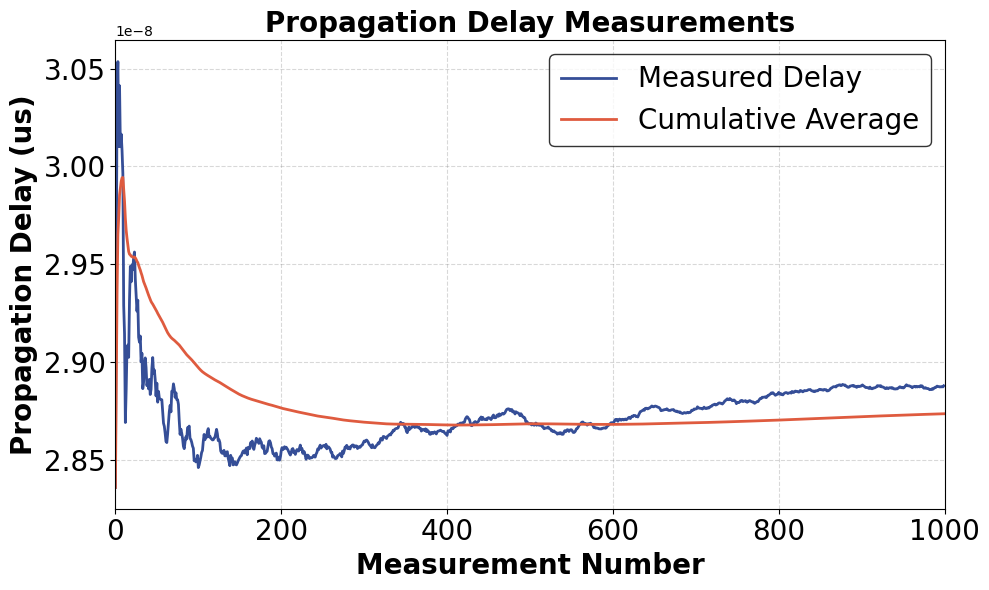

Average measured delay: 28.74 ns
Final cumulative average: 28.74 ns
Min delay: 28.36 ns
Max delay: 30.54 ns


In [14]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/3/20 10:30
*  @Project :   pj_gptp_simulation
*  @Description :   Visualize simulation results from CSV
*  @FileName:   data_visualizer.py
**************************************
"""
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def load_propagation_delay_data(filename="output_data/propagation_delay_3125ms.csv"):
    measurements = []
    delays = []
    avg_delays = []
    with open(filename, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            measurements.append(int(row["Measurement"]))
            delays.append(float(row["Delay"]))
            avg_delays.append(float(row["Cumulative_Avg"]))
    return measurements, delays, avg_delays

def plot_propagation_delay(measurements, delays, avg_delays):
    # 确保输出目录存在
    import os
    os.makedirs("output_image", exist_ok=True)

    # 设置颜色 (RGB值除以255得到0-1范围)
    delay_color = (53/255, 78/255, 151/255)  # RGB(053,078,151)
    avg_delay_color = (223/255, 91/255, 63/255)  # RGB(223,091,063)

    # 设置图表样式
    plt.style.use('default')  # 重置样式
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    
    # 绘制传播延迟图
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('white')  # Figure 背景设为白色
    ax.set_facecolor('white')  # 坐标轴区域背景设为白色
    
    # 设置轴和刻度颜色为黑色
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.tick_params(axis='both', colors='black')
    
    ax.plot(delays, color=delay_color, linestyle='-', label='Measured Delay', linewidth=2)
    ax.plot(avg_delays, color=avg_delay_color, linestyle='-', label='Cumulative Average', linewidth=2)
    
    # 设置图表元素
    ax.set_xlabel('Measurement Number', fontsize=20, fontweight='bold', color='black')
    ax.set_ylabel('Propagation Delay (us)', fontsize=20, fontweight='bold', color='black')
    ax.set_title('Propagation Delay Measurements', fontsize=20, fontweight='bold', color='black')
    ax.tick_params(axis='both', labelsize=20, colors='black')
    ax.set_xlim(0, 1000)
    
    # 添加图例和网格
    ax.legend(fontsize=20, frameon=True, shadow=False, edgecolor='black')
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)  # 设置灰色虚线网格
    
    plt.tight_layout()
    plt.savefig('output_image/propagation_delay_3125ms.png', facecolor='white', bbox_inches='tight')
    plt.show()
    plt.close()

    # 打印结果
    print(f"Average measured delay: {np.mean(delays) * 1e9:.2f} ns")
    print(f"Final cumulative average: {avg_delays[-1] * 1e9:.2f} ns")
    print(f"Min delay: {min(delays) * 1e9:.2f} ns")
    print(f"Max delay: {max(delays) * 1e9:.2f} ns")


if __name__ == "__main__":
    # 加载数据
    print("Loading simulation data...")
    # sync_data = load_sync_data()
    measurements, delays, avg_delays = load_propagation_delay_data()

    # 绘制传播延迟图
    print("\nPlotting propagation delay results...")
    plot_propagation_delay(measurements, delays, avg_delays)